In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

The assumed overfill is 10%.
The mean expected payout is $464.3 ($19.1).
The maximum expected payout is $475.6 ($7.8).
The minimum expected payout is $453.0 ($30.4).


C:\Users\kellyja\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


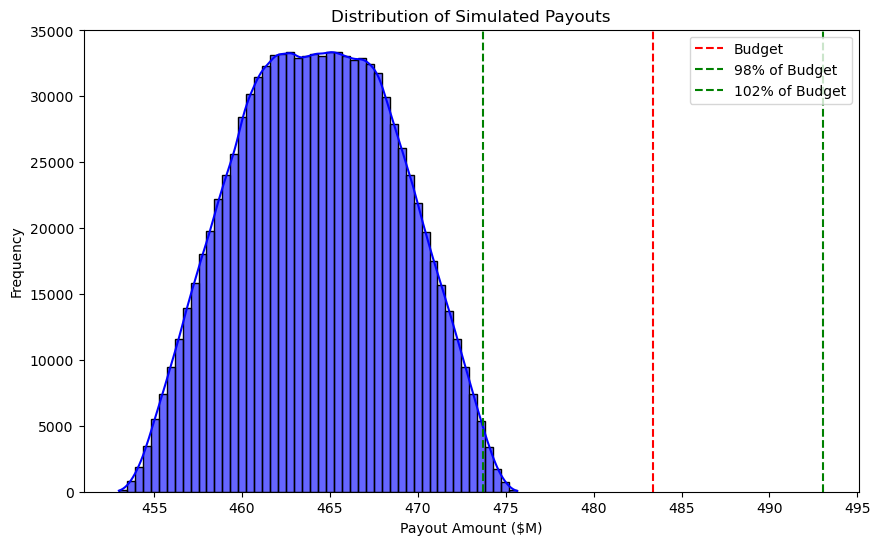

C:\Users\kellyja\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


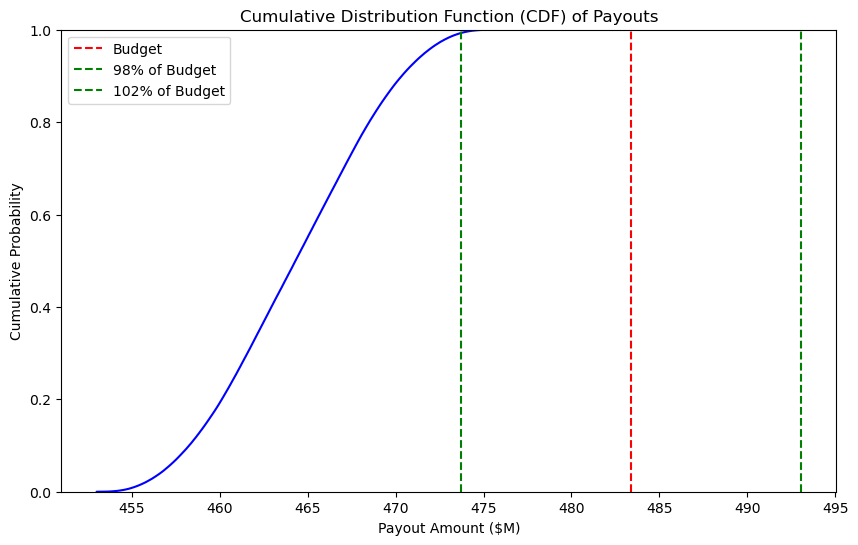


Overfill Sensitivity Analysis Probability:

 Overfill  Probability Within Budget Range
     0.00                         0.000000
     0.05                         0.000000
     0.10                         0.007040
     0.15                         0.361578
     0.20                         0.880522
     0.25                         0.715707
     0.30                         0.118769
     0.35                         0.000000
     0.40                         0.000000
     0.45                         0.000000
     0.50                         0.000000

Overfill Sensitivity Analysis Dollars:

 Overfill  Mean Payout ($M)
     0.00        451.693891
     0.05        457.666363
     0.10        464.309322
     0.15        471.725796
     0.20        480.069241
     0.25        489.527934
     0.30        500.330838
     0.35        512.807084
     0.40        527.343024
     0.45        544.548306
     0.50        565.175449


In [2]:
# Input variables
budget = 483.4
gavi = 329.5
paid = 8.7
subs = 65.4
initial = 1.4
contracts = 16.8
new = budget - gavi - paid - subs - initial - contracts

# Sensitivity range for overfill
overfill_values = np.linspace(0, 0.5, 11)  # Testing from 0% to 50% overfill in increments of 5%
sims = 1000000

# Attrition ranges
subs_attrit_low, subs_attrit_high = 0.08, 0.18 #point estimate is 13%
init_attrit_low, init_attrit_high = 0.01, 0.02 # point estimate is 33%, modified for early approved new, need to collapse new into this line
contr_attrit_low, contr_attrit_high = 0.12, 0.22 #point estimate is 17%
new_attrit_low, new_attrit_high = 0.23, 0.43 #point estimate is 33%, need to push this into initial line later in the year

# Probability ranges
between_low = budget * 0.98
between_high = budget * 1.02

# Storage for sensitivity analysis
sensitivity_results = []
sensitivity_mean_results = []

# Running simulation for different overfill levels
for overfill in overfill_values:
    subs_simulated = (subs / (1 - overfill)) * (1 - np.random.uniform(subs_attrit_low, subs_attrit_high, sims))
    init_simulated = (initial / (1 - overfill)) * (1 - np.random.uniform(init_attrit_low, init_attrit_high, sims))
    contr_simulated = (contracts / (1 - overfill)) * (1 - np.random.uniform(contr_attrit_low, contr_attrit_high, sims))
    new_simulated = (new / (1 - overfill)) * (1 - np.random.uniform(new_attrit_low, new_attrit_high, sims))
    
    payout_simulated = gavi + paid + subs_simulated + init_simulated + contr_simulated + new_simulated
    
    prob_between = np.sum((payout_simulated > between_low) & (payout_simulated < between_high)) / sims
    sensitivity_results.append([overfill, prob_between])

    mean_payout = np.mean(payout_simulated)
    sensitivity_mean_results.append([overfill, mean_payout])



# Convert results to DataFrame
df_sensitivity = pd.DataFrame(sensitivity_results, columns=["Overfill", "Probability Within Budget Range"])
df_sensitivity_mean = pd.DataFrame(sensitivity_mean_results, columns=["Overfill", "Mean Payout ($M)"])

# Display sensitivity results
def display_dataframe(name, dataframe):
    print(f"\n{name}:\n")
    print(dataframe.to_string(index=False))  # Displays the full DataFrame in a readable format


    
# Running one simulation with default overfill (0.12) for visualization
overfill = 0.10
subs_simulated = (subs / (1 - overfill)) * (1 - np.random.uniform(subs_attrit_low, subs_attrit_high, sims))
init_simulated = (initial / (1 - overfill)) * (1 - np.random.uniform(init_attrit_low, init_attrit_high, sims))
contr_simulated = (contracts / (1 - overfill)) * (1 - np.random.uniform(contr_attrit_low, contr_attrit_high, sims))
new_simulated = (new / (1 - overfill)) * (1 - np.random.uniform(new_attrit_low, new_attrit_high, sims))

payout_simulated = gavi + paid + subs_simulated + init_simulated + contr_simulated + new_simulated

# Headline stats
mean_payout = np.mean(payout_simulated)
max_payout = np.max(payout_simulated)
min_payout = np.min(payout_simulated)

# Statements
print(f"The assumed overfill is {overfill:.0%}.")
print(f"The mean expected payout is ${mean_payout:,.1f} (${(budget - mean_payout):,.1f}).")
print(f"The maximum expected payout is ${max_payout:,.1f} (${(budget - max_payout):,.1f}).")
print(f"The minimum expected payout is ${min_payout:,.1f} (${(budget - min_payout):,.1f}).")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
sns.histplot(payout_simulated, bins=50, kde=True, color="blue", alpha=0.6, ax=ax)
ax.axvline(budget, color="red", linestyle="--", label="Budget")
ax.axvline(between_low, color="green", linestyle="--", label="98% of Budget")
ax.axvline(between_high, color="green", linestyle="--", label="102% of Budget")

ax.set_title("Distribution of Simulated Payouts")
ax.set_xlabel("Payout Amount ($M)")
ax.set_ylabel("Frequency")
ax.legend()
plt.savefig("histogram.png", dpi=300, bbox_inches='tight')
plt.show()

# CDF Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.ecdfplot(payout_simulated, color="blue", ax=ax)
ax.axvline(budget, color="red", linestyle="--", label="Budget")
ax.axvline(between_low, color="green", linestyle="--", label="98% of Budget")
ax.axvline(between_high, color="green", linestyle="--", label="102% of Budget")

ax.set_title("Cumulative Distribution Function (CDF) of Payouts")
ax.set_xlabel("Payout Amount ($M)")
ax.set_ylabel("Cumulative Probability")
ax.legend()
plt.savefig("cdf.png", dpi = 300, bbox_inches='tight')
plt.show()

display_dataframe("Overfill Sensitivity Analysis Probability", df_sensitivity)
display_dataframe("Overfill Sensitivity Analysis Dollars", df_sensitivity_mean)

In [3]:
print(new)

61.59999999999998
